# Modelling 
We load the raw data, clean it, handle missing values, encode categorical features, and split into train/test sets.

### The models used include:
- Linear Regression
- Ridge Regression
- Lasso Regression
- Bayesian Ridge Regression
- Random Forest Regressor
- XGBoost Regressor
- CatBoost Regressor
- Bayesian Regression using PyMC

## Data Import and Preprocessing


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from preprocessing.preprocessing import preprocess_train_val
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load and drop columns
df_train_raw = pd.read_csv("../data/training.csv", sep="\t")
df_val_raw = pd.read_csv("../data/validation.csv", sep="\t")

# Preprocess the data
df_cleaned, _ = preprocess_train_val(df_train_raw, df_val_raw)

In [2]:
# List of categorical columns
cat_cols = ['DepartureAirport', 'ArrivalAirport', 'Route', 'FlightNumber', 'DepartureWeekday']

# Label encode categorical columns
X_full = df_cleaned.drop(columns=["ActualTOW"]).copy()
for col in cat_cols:
    le = LabelEncoder()
    X_full[col] = le.fit_transform(X_full[col].astype(str))

# Select only numeric columns for X_numeric
numeric_cols = X_full.columns[~X_full.columns.isin(cat_cols)]
X_numeric = X_full[numeric_cols]

y = df_cleaned["ActualTOW"]

In [3]:
# Split data into train and test (80/20 split)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y, test_size=0.2, random_state=42
)

X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(
    X_numeric, y, test_size=0.2, random_state=42
)

## Regression Models with Numeric Features Only
We train and evaluate linear models (Linear, Ridge, Lasso, Bayesian Ridge) using only numeric features.

In [34]:
from sklearn.linear_model import LinearRegression
# Initialize and fit the model
lr = LinearRegression()
lr.fit(X_train_num, y_train_num)

# Predict on the test set
y_pred = lr.predict(X_test_num)

# Evaluate with RMSE
rmse = np.sqrt(mean_squared_error(y_test_num, y_pred))
print(f"Linear Regression RMSE: {rmse:.2f}")


Linear Regression RMSE: 966.71


In [35]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_num, y_train_num)

y_pred_ridge = ridge.predict(X_test_num)
rmse_ridge = np.sqrt(mean_squared_error(y_test_num, y_pred_ridge))
print(f"Ridge Regression RMSE: {rmse_ridge:.2f}")


Ridge Regression RMSE: 966.71


In [36]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train_num, y_train_num)

y_pred_lasso = lasso.predict(X_test_num)
rmse_lasso = np.sqrt(mean_squared_error(y_test_num, y_pred_lasso))
print(f"Lasso Regression RMSE: {rmse_lasso:.2f}")


Lasso Regression RMSE: 966.71


In [37]:
from sklearn.linear_model import BayesianRidge

bayes_ridge = BayesianRidge()
bayes_ridge.fit(X_train_num, y_train_num)

y_pred_bayes = bayes_ridge.predict(X_test_num)
rmse_bayes = np.sqrt(mean_squared_error(y_test_num, y_pred_bayes))
print(f"Bayesian Ridge RMSE: {rmse_bayes:.2f}")


Bayesian Ridge RMSE: 966.71


## Regression Models with All Features (including Categorical)
We train and evaluate tree-based models (Random Forest, XGBoost, CatBoost) using both numeric and categorical features.


In [38]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_full, y_train_full)

y_pred_rf = rf.predict(X_test_full)
rmse_rf = np.sqrt(mean_squared_error(y_test_full, y_pred_rf))
print(f"Random Forest RMSE: {rmse_rf:.2f}")


Random Forest RMSE: 859.78


In [39]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train_full, y_train_full)

y_pred_xgb = xgb_model.predict(X_test_full)
rmse_xgb = np.sqrt(mean_squared_error(y_test_full, y_pred_xgb))
print(f"XGBoost RMSE: {rmse_xgb:.2f}")


XGBoost RMSE: 763.06


In [48]:
from catboost import CatBoostRegressor

cat_features = [X_train_full.columns.get_loc(col) for col in ['DepartureAirport', 'ArrivalAirport', 'Route', 'FlightNumber', 'DepartureWeekday']]

catboost = CatBoostRegressor(cat_features=cat_features, verbose=0, random_state=42)
catboost.fit(X_train_full, y_train_full)

y_pred_cat = catboost.predict(X_test_full)
rmse_cat = np.sqrt(mean_squared_error(y_test_full, y_pred_cat))
print(f"CatBoost RMSE: {rmse_cat:.2f}")


CatBoost RMSE: 732.19


## Bayesian Regression with PyMC
We implement Bayesian linear regression using PyMC, including standardization and posterior inference.


In [4]:
## Run only if you have a C++ compiler installed (such as g++ or mingw-w64)

import pymc as pm
import numpy as np
import pytensor.tensor as pt

X_train_np = X_train_full.values
y_train_np = y_train_full.values

from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Standardize input
X_train_scaled = scaler_X.fit_transform(X_train_full)
y_train_scaled = scaler_y.fit_transform(y_train_full.values.reshape(-1, 1)).ravel()

# Model
with pm.Model() as model:
    intercept = pm.Normal("intercept", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=1)
    coefs = pm.Normal("coefs", mu=0, sigma=tau, shape=X_train_scaled.shape[1])
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = intercept + pt.dot(X_train_scaled, coefs)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_train_scaled)

    trace = pm.sample(2000, tune=3000, chains=4, cores=2, target_accept=0.95)


# Posterior mean prediction

X_test_scaled = scaler_X.transform(X_test_full)
coefs_mean = trace.posterior["coefs"].mean(("chain", "draw")).values
intercept_mean = trace.posterior["intercept"].mean(("chain", "draw")).values

y_pred_scaled = X_test_scaled @ coefs_mean + intercept_mean
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

rmse_pymc = np.sqrt(mean_squared_error(y_test_full, y_pred))
print(f"Bayesian Regression (PyMC MCMC) RMSE: {rmse_pymc:.2f}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept, tau, coefs, sigma]


Output()

Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 1528 seconds.


Bayesian Regression (PyMC MCMC) RMSE: 966.28


C:\Users\Dominik\.conda\envs\myenv\Lib\site-packages\arviz\plots\plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (52) in plot_autocorr, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'intercept\n0'}>,
        <Axes: title={'center': 'intercept\n1'}>,
        <Axes: title={'center': 'intercept\n2'}>,
        <Axes: title={'center': 'intercept\n3'}>],
       [<Axes: title={'center': 'coefs\n0, 0'}>,
        <Axes: title={'center': 'coefs\n0, 1'}>,
        <Axes: title={'center': 'coefs\n0, 2'}>,
        <Axes: title={'center': 'coefs\n0, 3'}>],
       [<Axes: title={'center': 'coefs\n0, 4'}>,
        <Axes: title={'center': 'coefs\n0, 5'}>,
        <Axes: title={'center': 'coefs\n0, 6'}>,
        <Axes: title={'center': 'coefs\n0, 7'}>],
       [<Axes: title={'center': 'coefs\n0, 8'}>,
        <Axes: title={'center': 'coefs\n0, 9'}>,
        <Axes: title={'center': 'coefs\n1, 0'}>,
        <Axes: title={'center': 'coefs\n1, 1'}>],
       [<Axes: title={'center': 'coefs\n1, 2'}>,
        <Axes: title={'center': 'coefs\n1, 3'}>,
        <Axes: title={'center': 'coefs\n1, 4'}>,
        <Axes: title={'center': 'coefs\n1, 5'}>],
       [<Ax

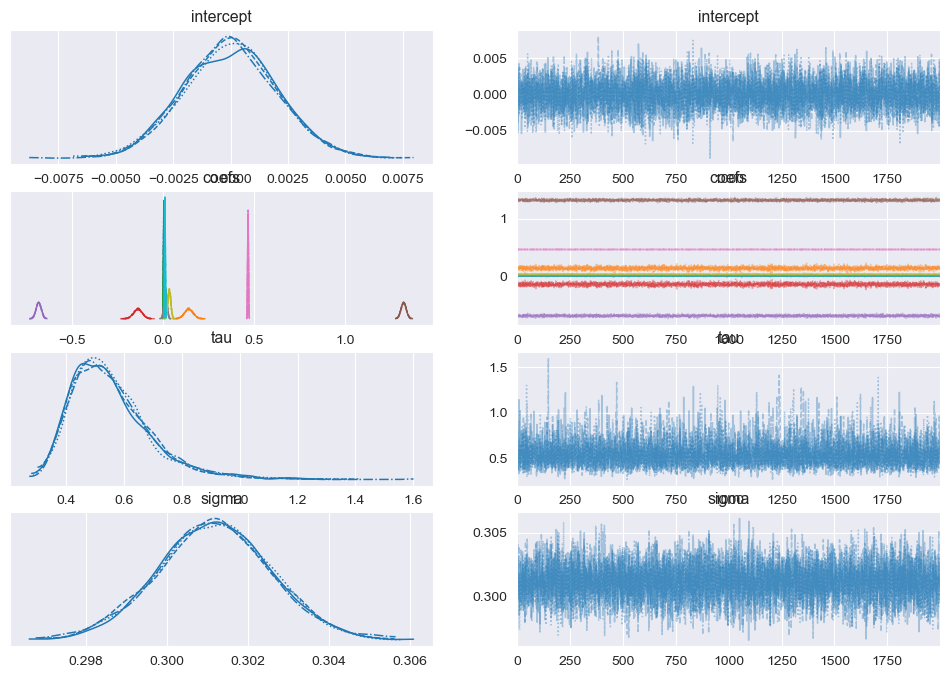

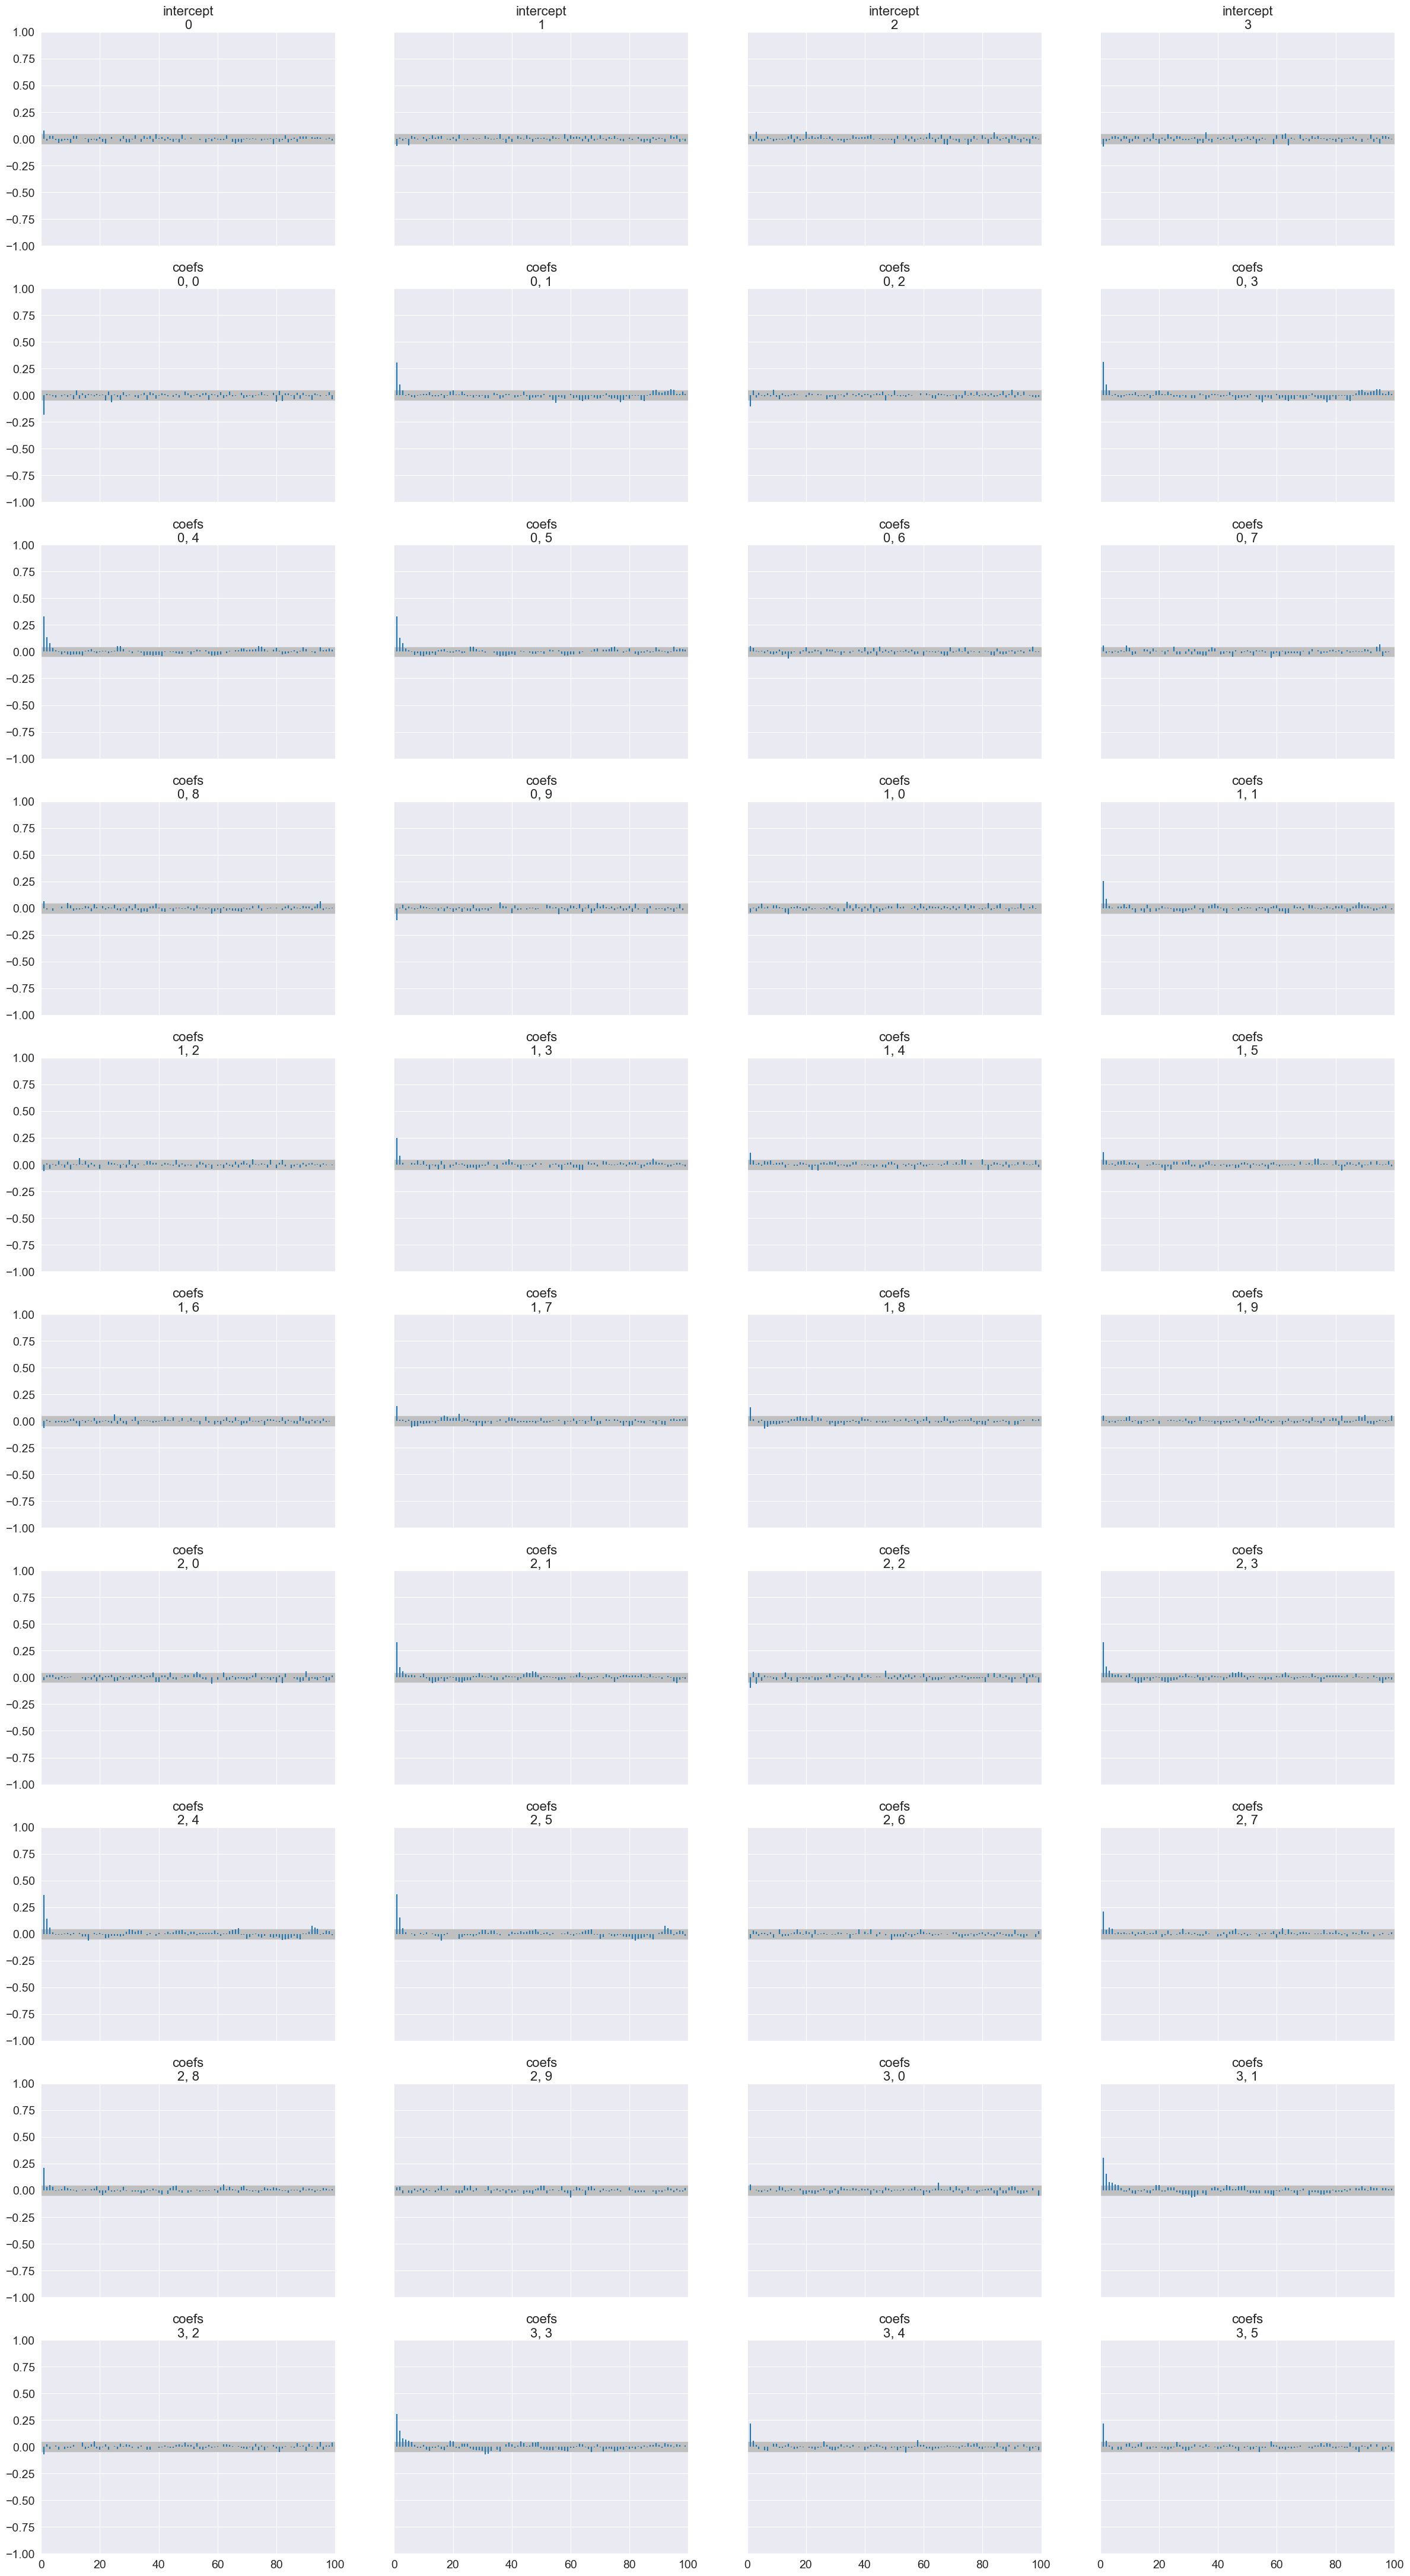

In [46]:
import arviz as az

az.plot_trace(trace)

az.summary(trace, round_to=2)
az.plot_autocorr(trace)

## Model Comparison
We evaluated multiple regression models using RMSE (Root Mean Squared Error) on a hold-out test set:

| Model                           | RMSE   |
|---------------------------------|--------|
| Linear Regression               | 966.71 |
| Ridge Regression                | 966.71 |
| Lasso Regression                | 966.71 |
| Bayesian Ridge                  | 966.71 |
| Random Forest                   | 859.78 |
| XGBoost                         | 763.06 |
| CatBoost                        | 732.19 |
| Bayesian Regression (PyMC MCMC) | 966.28 |

#### Observations:
- All linear models (Linear, Ridge, Lasso, Bayesian Ridge) performed identically, suggesting they captured similar patterns — and likely struggled with the non-linearity or complexity in the data.
- Tree-based models (Random Forest, XGBoost, CatBoost) performed significantly better, with CatBoost achieving the lowest RMSE.
- Bayesian Regression using PyMC MCMC had a similar RMSE to the linear models, indicating it also struggled with the dataset's complexity.
- This suggests that the dataset contains complex, possibly non-linear relationships that linear models fail to capture.
- CatBoost likely benefited from its ability to natively handle categorical variables.


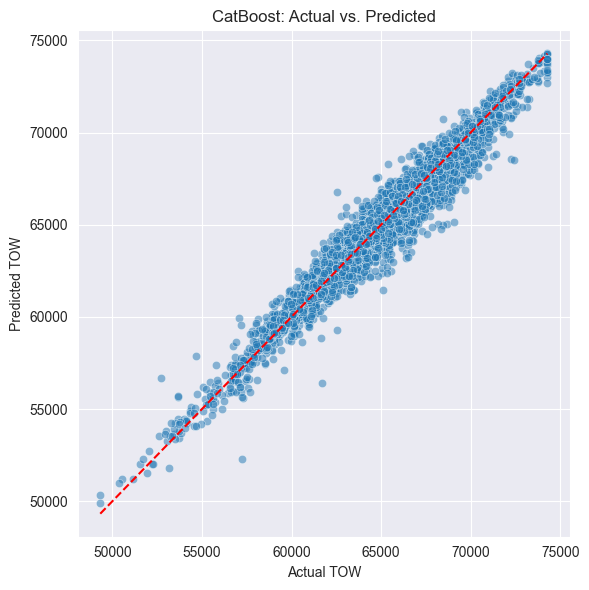

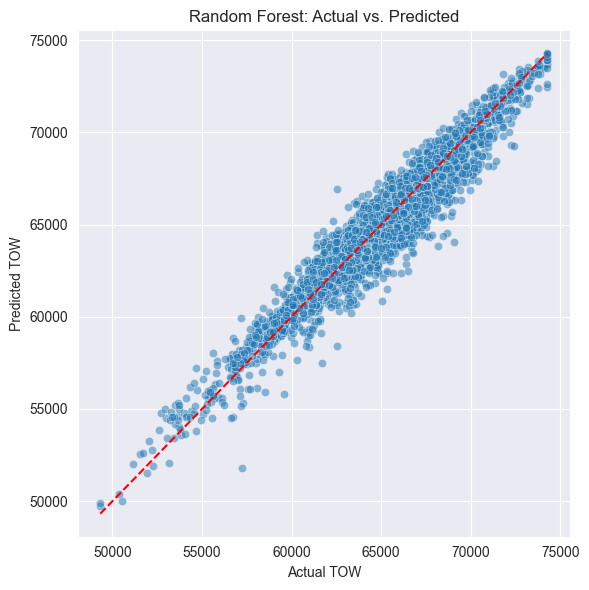

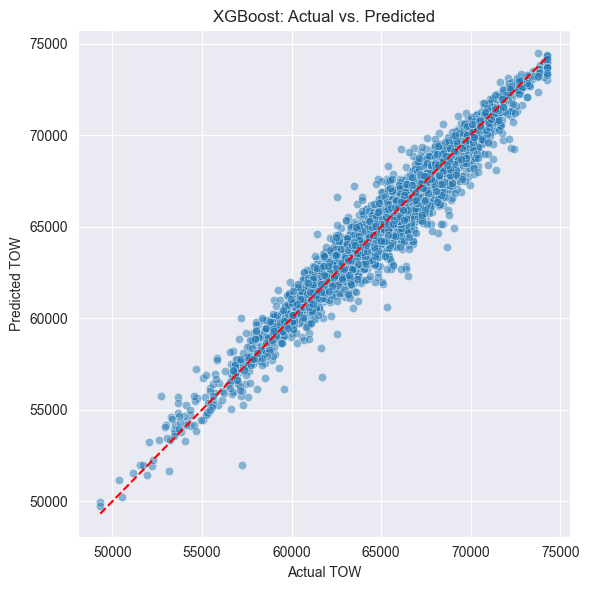

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_predictions(y_true, y_pred, title="Actual vs. Predicted"):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.xlabel("Actual TOW")
    plt.ylabel("Predicted TOW")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example for CatBoost
plot_predictions(y_test_full, y_pred_cat, title="CatBoost: Actual vs. Predicted")
plot_predictions(y_test_full, y_pred_rf, title="Random Forest: Actual vs. Predicted")
plot_predictions(y_test_full, y_pred_xgb, title="XGBoost: Actual vs. Predicted")


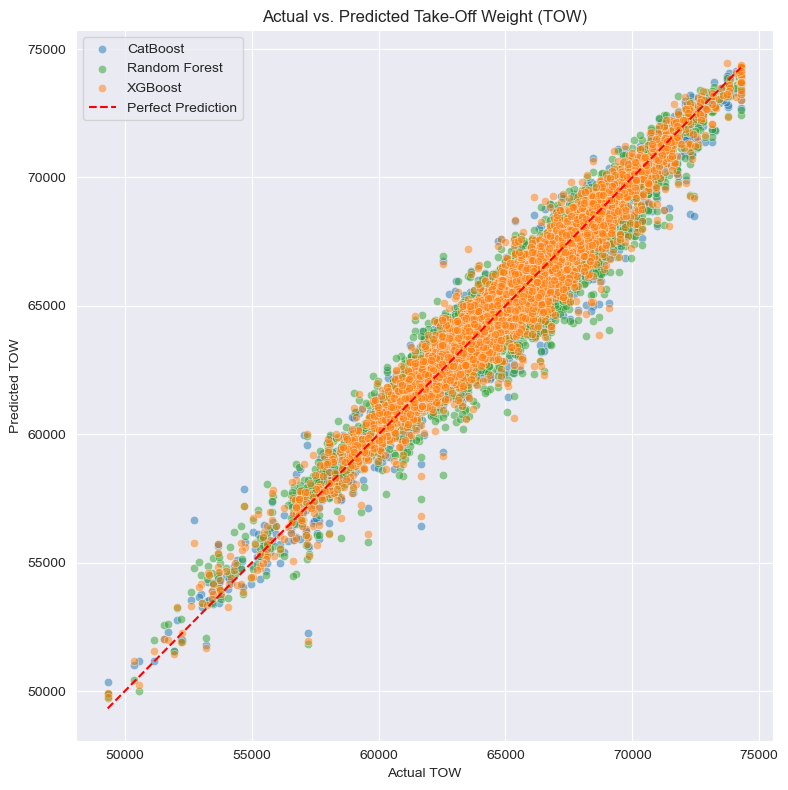

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))

# Plot predicted vs actual for each model
sns.scatterplot(x=y_test_full, y=y_pred_cat, label="CatBoost", alpha=0.5, color="tab:blue")
sns.scatterplot(x=y_test_full, y=y_pred_rf, label="Random Forest", alpha=0.5, color="tab:green")
sns.scatterplot(x=y_test_full, y=y_pred_xgb, label="XGBoost", alpha=0.5, color="tab:orange")

# Reference line
min_val, max_val = y_test_full.min(), y_test_full.max()
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="Perfect Prediction")

plt.xlabel("Actual TOW")
plt.ylabel("Predicted TOW")
plt.title("Actual vs. Predicted Take-Off Weight (TOW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


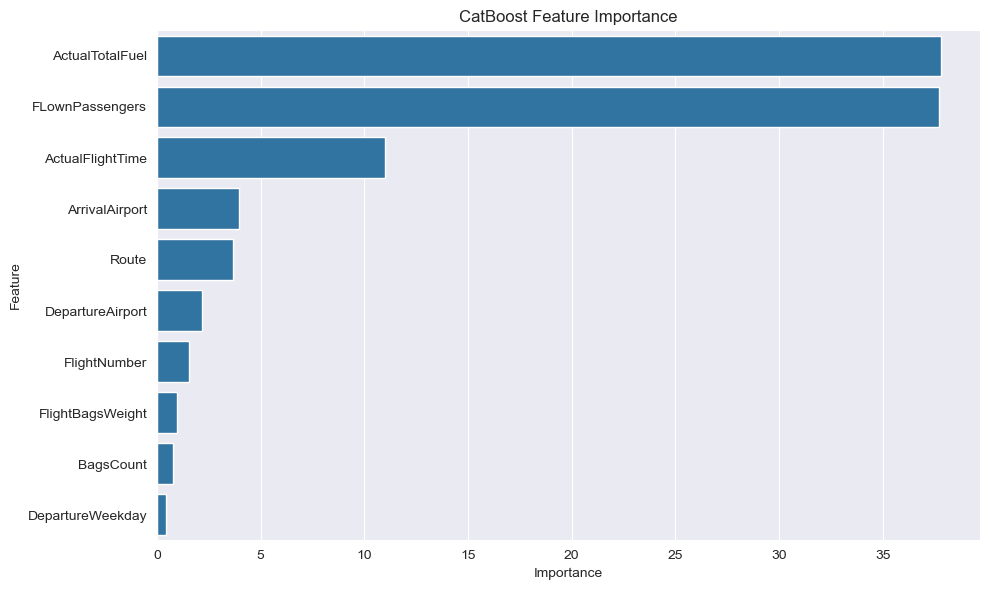

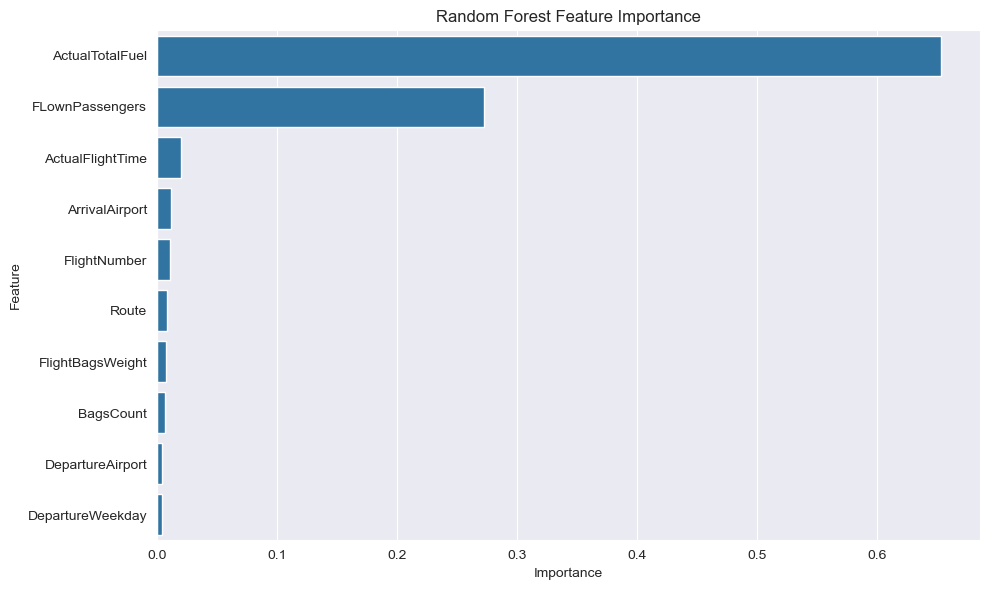

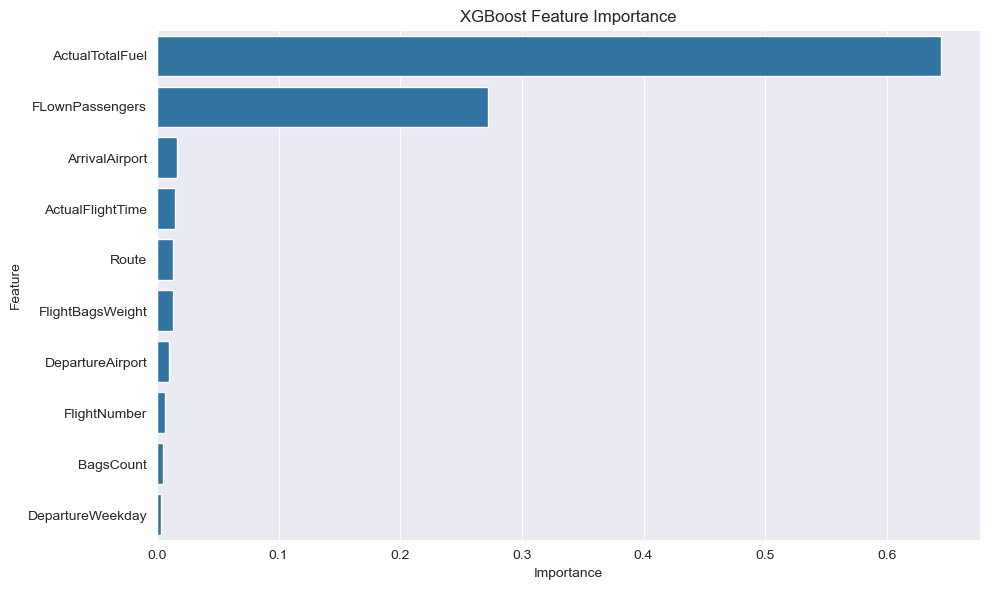

In [50]:
    # Feature Importance for CatBoost
import matplotlib.pyplot as plt
import seaborn as sns
feature_importances = catboost.get_feature_importance()
feature_names = X_train_full.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Feature Importance for Random Forest
importance_rf = rf.feature_importances_
importance_rf_df = pd.DataFrame({
    'Feature': X_train_full.columns,
    'Importance': importance_rf
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_rf_df)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Feature Importance for XGBoost
importance_xgb = xgb_model.feature_importances_
importance_xgb_df = pd.DataFrame({
    'Feature': X_train_full.columns,
    'Importance': importance_xgb
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_xgb_df)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Model Selection Justification
After testing multiple regression models, including Linear Regression, Ridge, Lasso, Bayesian Ridge, Random Forest, and XGBoost, the **CatBoost Regressor** emerged as the best-performing model with an RMSE of **732.19** on the hold-out test set.

A potential concern was CatBoost's heavy reliance on the `FLownPassengers` feature, which accounted for **~38%** of the model’s feature importance. However, this concern is mitigated by the fact that **only 0.48% of `FLownPassengers` values are missing** in the validation set. This means that the feature is nearly complete and its influence on model accuracy is well-founded.

By contrast, features with more substantial missingness—such as `BagsCount` (8.95%) and `FlightBagsWeight` (9.64%)—contributed very little to the model's predictions, both in CatBoost and other models.

CatBoost also natively handles categorical variables without requiring manual encoding, making it highly suitable for the dataset’s structure. Its combination of high accuracy, low imputation risk, and strong support for mixed feature types makes it the optimal choice for final prediction.
